In [18]:
#sandbox = 'fper' 
#PATH_DATA = '/data/sandboxes/'+sandbox+'/data/data/'

In [19]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar -xvf spark-3.2.0-bin-hadoop2.7.tgz

spark-3.2.0-bin-hadoop2.7/
spark-3.2.0-bin-hadoop2.7/NOTICE
spark-3.2.0-bin-hadoop2.7/kubernetes/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop2.7/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop2.7/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop2.7/kubernetes/docker

In [20]:
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"



# Prueba de Spark

Cargamos un dataset con información de una campaña de marketing portuguesa para la venta de un préstamo bancario. El objetivo es predecir si un cliente en cuestión comprará el producto o no.



## Información sobre las variables del dataset

### Datos del cliente bancario
1. age
2. job: tipo de trabajo
3. marital: estado civil (nota: "divorced" implica tanto divorciado como viudo)
4. education
5. default: ¿no ha pagado alguna cuota de un crédito?
6. balance: saldo medio anual, en euros
7. housing: ¿tiene una hipoteca?
8. loan: ¿tiene un crédito?

### Relacionado con el último contacto con el cliente en la campaña actual
9. contact: tipo de comunicación del último contacto 
10. day: día de la fecha de último contacto
11. month: mes de la fecha de último contacto
12. duration: duración del último contacto, en segundos

### Otros atributos:
13. campaign: número de contactos llevados a cabo durante esta campaña y para este cliente (incluye el último contacto)
14. pdays: número de dias que han pasado desde que el cliente fue contactado por última vez durante la pasada campaña (-1 significa que el cliente no fue contactado)
15. previous: número de contactos que se han llevado a cabo antes de esta campaña y para este cliente 
16. poutcome: resultado de la última campaña de marketing

### Variable de salida (target):
17. y: ¿tiene el cliente contratado un depósito a plazo fijo?

In [21]:
import findspark
findspark.init()

findspark.find()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

# Librerías:

In [22]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType, DoubleType, DateType
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest
sns.set(color_codes=True)

from pyspark.sql.types import StringType, DoubleType, IntegerType, ArrayType, DateType
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re

#Lectura de datos

In [23]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
from pyspark import SQLContext
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
sql = SQLContext(sc)

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


#Cargar data compartida

In [24]:
bank_df = spark.read.csv('bank-full.csv', sep=';', header=True, inferSchema=True)

#Instrucciones
Se pide realizar las siguientes acciones, dejando la descripción del paso a paso que se sigue en cada punto solicitado:


*   Vista de los primeros 10 datos de la data cargada junto con mensajes que muestren el número de datos y de variables

*   Identificar las variables cualitativas y cuantitativas

*   Validar si hay registros duplicados

*   Obtener estadísticos de las variables

*   Evaluar valores perdidos en las variables y proponer que hacer con esos casos

*   Hacer un estudio de las variables categóricas encontradas en la data

*   Análisis de valores outliers en las variables y que se propone realizar con dichos casos

*   Proponer y aplicar tratamiento de variables para maximizar su contribución a los modelos propuestos

*   Análisis Bivariante con respecto a la variable target

*   Proponer dos modelos, justificando su uso, presentado sus principales métricas, así como los supuestos aplicados y limitaciones

*   Colocar los resultados y conclusiones en una ppt

*   El entregable final es la ppt y el notebook


Suerte!!














## Load & Libraries

In [25]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import QuantileDiscretizer
from pyspark.ml.feature import RobustScaler
from pyspark.sql.functions import *


bank_df = spark.read.csv('bank-full.csv', sep=';', header=True, inferSchema=True)


## Label encoding

In [26]:
#indexer(label encoding)
columnList_strings = [item[0] for item in bank_df.dtypes if item[1].startswith('string')]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in columnList_strings]

pipeline = Pipeline(stages=indexers)
df_r = pipeline.fit(bank_df).transform(bank_df)


## Outliers

In [27]:
df_r= df_r.filter(df_r["previous"]<42)
df_r= df_r.filter(df_r["balance"]<60000)


## Binning

In [28]:
discretizer = QuantileDiscretizer(numBuckets=5, inputCol="campaign", outputCol="campaign_binned", relativeError=0.01, handleInvalid="error")
df_r = discretizer.setHandleInvalid("keep").fit(df_r).transform(df_r)

## Scaling

In [29]:
#scaling
columns_to_scale1 = ["balance"]
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in columns_to_scale1]
#robust scaler
scalers = [RobustScaler(inputCol=col + "_vec", outputCol=col + "_scaled", withScaling=True, withCentering=False,
                      lower=0.25, upper=0.75) for col in columns_to_scale1]
pipeline = Pipeline(stages=assemblers + scalers)
df_r = pipeline.fit(df_r).transform(df_r)


## Data Preprocessing

In [30]:
#to_integer
columnList_double = [item[0] for item in df_r.dtypes if item[1].startswith('double')]
for c in columnList_double:
  df_r = df_r.withColumn(c, col(c).cast('integer'))


#concat day & month
df_r=df_r.withColumn("day_month",concat(col('day'),lit(""),col('month_index')))
df_r = df_r.withColumn("day_month", col("day_month").cast('integer'))


index_cols = [x for x in df_r.columns if x.endswith("_index")]
numeric_cols = [item[0] for item in bank_df.dtypes if item[1].startswith('int')]


logisticdata = df_r.select(*index_cols,*numeric_cols,"campaign_binned","balance_scaled","day_month")


columns_to_drop = ['month_index', 'day']
logisticdata = logisticdata.drop(*columns_to_drop)

assembler = VectorAssembler(inputCols= logisticdata.drop("y_index").columns, outputCol="features",handleInvalid="keep")
logisticdata2 = assembler.transform(logisticdata)
logisticdata2=logisticdata2.select("y_index","features")


## Train & test split 

In [49]:
test, train = logisticdata2.randomSplit(weights=[0.15, 0.85],  seed=12345)


## Logistic regression

In [71]:
lr = LogisticRegression(labelCol="y_index", featuresCol="features", maxIter=100, regParam=0.001, elasticNetParam=1, standardization=True)

lrModel = lr.fit(train)
predictions = lrModel.transform(test)


In [72]:
trainingSummary = lrModel.summary
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

Accuracy: 0.8985208567031018
FPR: 0.6209077303379824
TPR: 0.8985208567031018
F-measure: 0.8818297284111525
Precision: 0.8815855880889151
Recall: 0.8985208567031018


## ROC Curve

/content/spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


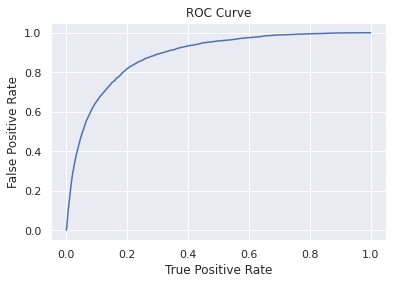

Training set areaUnderROC: 0.8836726698695317


In [73]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Gradient-boosted tree classifier

In [59]:
gbt = GBTClassifier(labelCol="y_index", featuresCol="features", maxIter=10)
pipeline = Pipeline(stages=[gbt])
lrModel = pipeline.fit(train)
predictions = lrModel.transform(test)

In [68]:
accuracy = predictions.filter(predictions.y_index == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.9028546460821439


## Feature Importances

In [52]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))

In [54]:
ExtractFeatureImp(lrModel.stages[-1].featureImportances, predictions, "features").head(10)

,idx,name,score
10,10,duration,0.392406
16,16,day_month,0.139066
4,4,housing_index,0.082102
6,6,contact_index,0.081388
7,7,poutcome_index,0.071259
8,8,age,0.070072
12,12,pdays,0.044890
9,9,balance,0.025052
11,11,campaign,0.021272
14,14,campaign_binned,0.017773


## Confusion Matrix

In [38]:
class_names=[1.0,0.0]
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 267  535]
 [ 132 5932]]


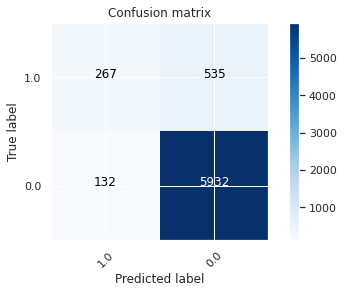

In [69]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("y_index")
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
#cnf_matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()